In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from scipy.io import loadmat
from scipy import stats, signal

import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys
import time

from sklearn.decomposition import PCA, SparsePCA, KernelPCA, NMF, FastICA
from sklearn.manifold import Isomap
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer

import torch
from torch import nn
from torch import functional as F

from pathlib import Path
with open("../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
sys.path.insert(0, str(utils_path))

from data_utils_lesha import process_file, process_all_files, process_string

train_path = data_path / "train"
test_path  = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

fnames_train = os.listdir(train_path)
fnames_test = os.listdir(test_path)
fnames_holdout = os.listdir(holdout_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First let's align input data

We need to pad it to 3000 samples and reduce to 80 components

## Load train and test data

In [11]:
%%time
data_train = process_all_files(train_path)
data_test = process_all_files(test_path)

data_test.keys()

CPU times: user 12.8 s, sys: 4.85 s, total: 17.7 s
Wall time: 20.3 s


dict_keys(['voltage_list', 'spike_list', 'sentence_list', 'date_list'])

## Process BRAIN DATA

**Which inputs the model expects?**

- 30 seconds of 16 kHz audio
- it gets preprocessed by WhisperFeatureExtractor to a spectrogram of size 80 x 3000
- so 30 sec of 100 Hz sampling rate)

## New processing: prepare data without dimensionality reduction

### Torch dataset which handles processing

- Normalization: (scalers should be trained already)
- Augmentations: adding noise, speeding/slowing up
- Padding
- Creating torch tensors

### Train scalers for voltages and spikes

In [47]:
%%time
XV = np.concatenate(data_test['voltage_list'], axis=0)
scalerV = QuantileTransformer(n_quantiles=3000, output_distribution='uniform', subsample=30000).fit(XV)
XVs = scalerV.transform(XV)

CPU times: user 12.3 s, sys: 110 ms, total: 12.4 s
Wall time: 12.4 s


In [73]:
class CompositeScaler:

    def __init__(self, scaler_list, scaler_kwargs_list={}):
        """ scaler_list provided in asceding order: first scaler applied first"""
        self.scalers = scaler_list
        self.scaler_kwargs_list = {}

    def fit(self, X):
        for scaler in self.scalers:
            X = scaler.fit_transform(X)

    def transform(self, X):
        for scaler in self.scalers:
            X = scaler.transform(X)
        return X

    def fit_transform(self, X):
        for scaler in self.scalers:
            X = scaler.fit_transform(X)
        return X

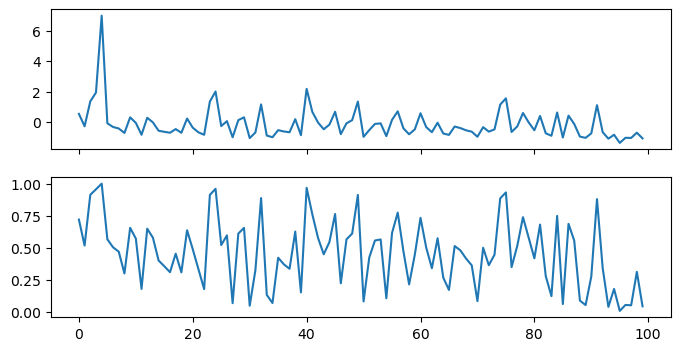

In [54]:
chan = 100

start = 1000
window = 100
timeslice = slice(start, start + window)

fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
axes[0].plot(XV[timeslice, chan].T)
axes[1].plot(XVs[timeslice, chan].T)

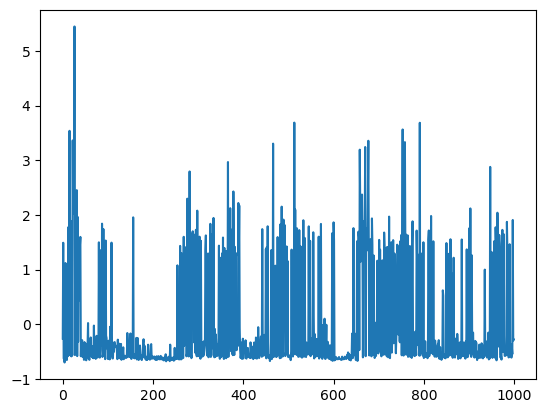

In [33]:
%%time
XS = np.concatenate(data_test['spike_list'], axis=0)
scalerS = MinMaxScaler(feature_range=(-1, 1)).fit(XS)
XSs = scalerS.transform(XS)

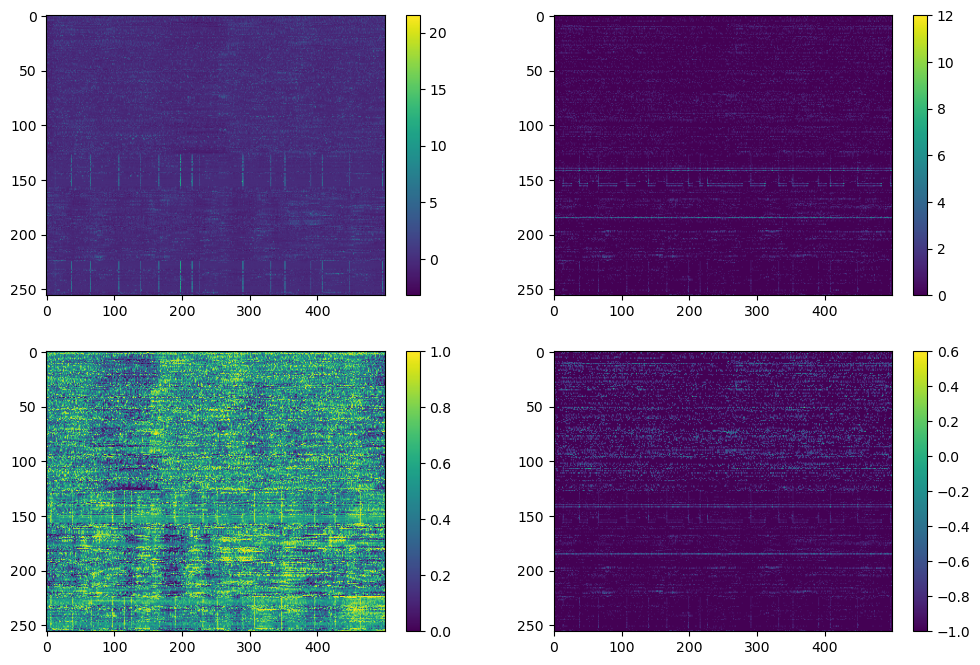

In [40]:
start = 0
window = 500
timeslice = slice(start, start + window)

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(XV[timeslice, :].T, aspect='auto')
plt.colorbar()

plt.subplot(223)
plt.imshow(XVs[timeslice, :].T, aspect='auto')
plt.colorbar()

plt.subplot(222)
plt.imshow(XS[timeslice, :].T, aspect='auto')
plt.colorbar()

plt.subplot(224)
plt.imshow(XSs[timeslice, :].T, aspect='auto')
plt.colorbar()

In [55]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, LowPassFilter

In [62]:
augment = Compose([
    LowPassFilter(10, 25, zero_phase=True),
    TimeStretch(min_rate=0.95, max_rate=1.05, p=0.5, leave_length_unchanged=False),
    AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.015, p=0.5),
])

/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=100
  warnings.warn(


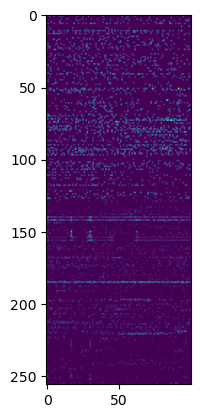

In [69]:
XSsa = augment(XSs[timeslice, :].T, sample_rate=50)
plt.imshow(XSs[timeslice, :].T)

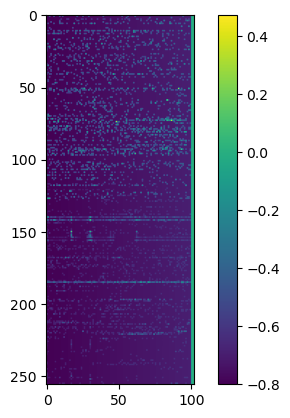

In [71]:
plt.imshow(XSsa)
plt.colorbar()

In [74]:
augment = Compose([
    LowPassFilter(10, 25, zero_phase=True),
    TimeStretch(min_rate=0.95, max_rate=1.05, p=0.5, leave_length_unchanged=False),
    AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.015, p=0.5),
])

In [76]:
class WhisperBrainDataset(Dataset):
    
    def __init__(self, 
                 voltage_list, 
                 spike_list, 
                 sentence_list, 
                 voltage_scaler, 
                 spike_scaler, 
                 tokenizer, 
                 augment,
                 fs_orig=50, 
                 fs_whisper=100, 
                 max_duration=30, 
                 is_eval=False):
        
        self.voltage_list = voltage_list
        self.spike_list = spike_list
        self.sentence_list = sentence_list
        
        self.tokenizer = tokenizer
        self.voltage_scaler = voltage_scaler
        self.spike_scaler = spike_scaler

        self.augment = augment
        self.fs_orig = fs_orig
        self.fs_whisper = fs_whisper
        self.max_duration = max_duration
        self.is_eval = is_eval

    def __len__(self):
        return len(self.voltage_list)

    def __getitem__(self, idx):

        # to set to -1 to +1 range
        XV_scaled = self.voltage_scaler.transform(self.voltage_list[idx]) * 2 - 1 
        XS_scaled = self.spike_scaler.transform(self.spike_list[idx])

        # concatenate and transpose
        X_concat = np.concatenate(XS_scaled, XV_scaled, axis=1).T # get 512 channels x times array

        # resample from orig sampling rate to desired one
        scaling = int(self.fs_whisper / self.fs_orig)
        sig_length = X_concat.shape[1]
        X_resampled = signal.resample(X_concat, sig_length * scaling, axis=1)
        
        # augment if it's a train dataset
        if not self.is_eval:
            X_aug = self.augment(X_resampled, sample_rate=self.fs_whisper)

        # pad to a desired input length (3000 in case of Whisper)
        n_samples = X_aug.shape[0]
        max_samples = int(self.max_duration * self.fs_whisper)

        X_pad = np.pad(data_resampled, [(0, 0), (0, max_samples - n_samples)])
        
        input_features = X_pad

        # process (tokenize) the sentence
        sentence = self.sentences_list[idx]
        labels = self.tokenizer(sentence, return_tensors="pt").input_ids.squeeze()

        return {
            "input_features": torch.tensor(input_features),
            "labels": labels,
        }
        

NameError: name 'Dataset' is not defined

In [ ]:
nn.functional.pad()

In [ ]:
def prepare_brain_data_for_whisper(brain_list, fs_orig=50, fs_new=100):
    
    # initialize output array 
    brain_processed_arr = np.empty(len(brain_list), dtype=object)
    
    for i, data in enumerate(brain_list):
        
        # reduce to 80 components and transpose to (n_chan, n_times)
        data_transformed = compressor.transform(data)[:, :n_components].T # [80 x n]
        n_times = data_transformed.shape[1]
        
         # resample from 50 Hz to 100 Hz
        scaling = int(fs_new / fs_orig)
        data_resampled = signal.resample(data_transformed, n_times * scaling, axis=1)
        
        # fill in values
        brain_processed_arr[i] = data_resampled
    
    return brain_processed_arr

### Train PCA

We want to compress the data to 80 components

In [3]:
%%time

brain_list = data_train['voltage_list']
X = np.concatenate(brain_list, axis=0) # take only voltages
print(X.shape)

pca = PCA().fit(X)

(2768768, 256)
CPU times: total: 46.8 s
Wall time: 22.3 s


In [4]:
def prepare_brain_data_for_whisper(brain_list, pca, n_components=80, pad_length=3000):
    
    # initialize output array 
    brain_processed_arr = np.empty((len(brain_list), n_components, pad_length))  # [N x 80 x 3000]
    
    for i, data in enumerate(brain_list):
        data = data[:, :256]
        # reduce to 80 components and transpose to (n_chan, n_times)
        data_transformed = pca.transform(data)[:, :n_components].T # [80 x n]
        n_times = data_transformed.shape[1]
         # resample from 50 Hz to 100 Hz
        data_resampled = signal.resample(data_transformed, n_times * 2, axis=1)
        # pad to 30 sec (3000 samples in 100 Hz sampling rate)
        data_padded = np.pad(data_resampled, [(0, 0), (0, pad_length - n_times * 2)])
        # fill in values
        brain_processed_arr[i] = data_padded
    
    return brain_processed_arr

### Process data

In [5]:
%%time
brain_arr_train = prepare_brain_data_for_whisper(data_res_train['brain_list'], pca)
brain_arr_train.shape

CPU times: total: 3.7 s
Wall time: 35.1 s


(8800, 80, 3000)

In [9]:
%%time
brain_arr_test = prepare_brain_data_for_whisper(data_res_test['brain_list'], pca)
brain_arr_test.shape

CPU times: total: 203 ms
Wall time: 2.31 s


(880, 80, 3000)

For me it has more of both elements than the majority of its competitors.


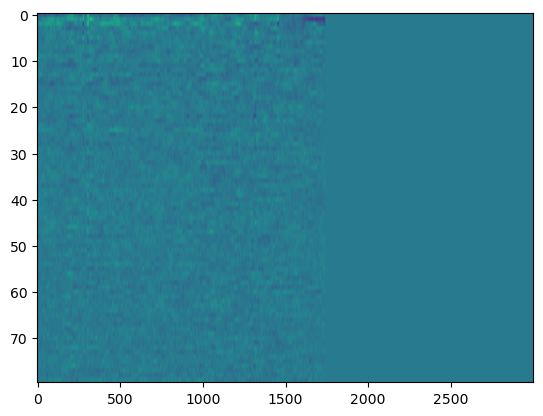

In [36]:
plt.imshow(brain_arr_train[100], aspect='auto')
print(data_res_train['sentence_list'][100])

### Save resulting files

In [7]:
np.save(data_path / "whisper_brain_arr_train.npy", brain_arr_train)
np.save(data_path / "whisper_brain_arr_test.npy", brain_arr_test)

In [ ]:
features_train = np.load(data_path / "whisper_brain_arr_train.npy")
features_test = np.load(data_path / "whisper_brain_arr_test.npy")

### Train NMF

We want to compress the data to 80 components

In [11]:
%%time

brain_list = data_train['spike_list']
X = np.concatenate(brain_list, axis=0) # take only voltages
print(X.shape)

model = NMF(n_components=80).fit(X)

(2768768, 256)


KeyboardInterrupt: 

In [4]:
def prepare_brain_data_for_whisper(brain_list, compressor, n_components=80, fs_orig=50, fs_new=100):
    
    # initialize output array 
    brain_processed_arr = np.empty(len(brain_list), dtype=object)
    
    for i, data in enumerate(brain_list):
        
        # reduce to 80 components and transpose to (n_chan, n_times)
        data_transformed = compressor.transform(data)[:, :n_components].T # [80 x n]
        n_times = data_transformed.shape[1]
        
         # resample from 50 Hz to 100 Hz
        scaling = int(fs_new / fs_orig)
        data_resampled = signal.resample(data_transformed, n_times * scaling, axis=1)
        
        # fill in values
        brain_processed_arr[i] = data_resampled
    
    return brain_processed_arr

In [16]:
XV = np.concatenate(data_train['voltage_list'], axis=0)
XS = np.concatenate(data_train['spike_list'], axis=0)

(2768768, 256)

In [36]:
import pandas as pd

In [74]:
model_names = ["PCA", "NMF", "ICA", "sPCA", "kPCA-linear", "kPCA-poly", "kPCA-cosine", "kPCA-rbf", "Isomap"]

column_names = ["model", "signal", "n_emb", "t_fit", "t_transform", "error"]
df = pd.DataFrame(columns=column_names)


frac_n = 0.005
max_idx = XV.shape[0]
n_rand = int(max_idx * frac_n)
rand_idx = np.random.permutation(np.arange(max_idx))[:n_rand]

print(XV[rand_idx].shape)
print(f"Using {frac_n * 100}% of data to fit.\n")

M = len(model_names)
compressor_objects = {"spikes": [[None for _ in range(M)],[None for _ in range(M)]],
                      "voltages": [[None for _ in range(M)],[None for _ in range(M)]]}

for i, n in enumerate([40, 80]):

    print(f" || FITTING TO {n} COMPONENTS || \n")

    compressors = [PCA(n), NMF(n, max_iter=500), FastICA(n), SparsePCA(n, n_jobs=8),
                   KernelPCA(n, kernel="linear", fit_inverse_transform=True),
                   KernelPCA(n, kernel="poly", fit_inverse_transform=True), 
                   KernelPCA(n, kernel="cosine", fit_inverse_transform=True),
                   KernelPCA(n, kernel="rbf", fit_inverse_transform=True),
                   Isomap(n_components=n, n_neighbors=5, n_jobs=8, metric='cosine')]

    for j, compressor in enumerate(compressors):

        XVr = XV[rand_idx].astype(np.float32)
        XSr = XS[rand_idx].astype(np.float32)
        
        if model_names[j] == "NMF":
            XVr -= np.min(XVr)
            XSr -= np.min(XSr) 

        print(f"Fitting {model_names[j]} on VOLTAGES...\n")
        print(compressor.__class__.__name__)
        
        t0 = time.perf_counter()
        compressor.fit(XVr)  
        t1 = time.perf_counter()
        XV_transformed = compressor.transform(XVr)
        t2 = time.perf_counter()
        try:
            XV_reconstructed = compressor.inverse_transform(XV_transformed)
            error = np.linalg.norm(XV_reconstructed - XVr) / n_rand    
        except:
            if model_names[j] == "Isomap":
                error = compressor.reconstruction_error()

        compressor_objects["voltages"][i][j] = compressor

        row = {}
        row['model'] = model_names[j]
        row['signal'] = 'voltage'
        row['n_emb'] = n
        row['t_fit'] = np.round(t1 - t0, 3)
        row['t_transform'] = np.round(t2 - t1, 3)
        row['error'] = np.round(error, 3)

        print(row)
        df.loc[len(df)] = row

        print(f"Total elapsed time: {time.perf_counter() - t0:.3}sec\n")
        
        print(f"Fitting {model_names[j]} on SPIKES...\n")
        
        
        t0 = time.perf_counter()
        compressor.fit(XVr)  
        t1 = time.perf_counter()
        XS_transformed = compressor.transform(XSr)
        t2 = time.perf_counter()
        try:
            XS_reconstructed = compressor.inverse_transform(XS_transformed)
            error = np.linalg.norm(XS_reconstructed - XSr) / n_rand    
        except:
            if model_names[j] == "Isomap":
                error = compressor.reconstruction_error()

        compressor_objects["spikes"][i][j] = compressor

        row = {}
        row['model'] = model_names[j]
        row['signal'] = 'spikes'
        row['n_emb'] = n
        row['t_fit'] = np.round(t1 - t0, 3)
        row['t_transform'] = np.round(t2 - t1, 3)
        row['error'] = np.round(error, 3)

        print(row)
        df.loc[len(df)] = row

        print(f"Total elapsed time: {time.perf_counter() - t0:.3}sec\n")

(13843, 256)
Using 0.5% of data to fit.

 || FITTING TO 40 COMPONENTS || 

Fitting PCA on VOLTAGES...

PCA
{'model': 'PCA', 'signal': 'voltage', 'n_emb': 40, 't_fit': 0.301, 't_transform': 0.004, 'error': 0.116}
Total elapsed time: 0.314sec

Fitting PCA on SPIKES...

{'model': 'PCA', 'signal': 'spikes', 'n_emb': 40, 't_fit': 0.068, 't_transform': 0.004, 'error': 0.015}
Total elapsed time: 0.0814sec

Fitting NMF on VOLTAGES...

NMF
{'model': 'NMF', 'signal': 'voltage', 'n_emb': 40, 't_fit': 1.296, 't_transform': 5.943, 'error': 0.117}
Total elapsed time: 7.25sec

Fitting NMF on SPIKES...

{'model': 'NMF', 'signal': 'spikes', 'n_emb': 40, 't_fit': 1.181, 't_transform': 0.439, 'error': 0.015}
Total elapsed time: 1.63sec

Fitting ICA on VOLTAGES...

FastICA
{'model': 'ICA', 'signal': 'voltage', 'n_emb': 40, 't_fit': 0.74, 't_transform': 0.02, 'error': 0.115}
Total elapsed time: 0.771sec

Fitting ICA on SPIKES...

{'model': 'ICA', 'signal': 'spikes', 'n_emb': 40, 't_fit': 0.646, 't_transfor

/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=1.535e-04, previous alpha=1.535e-04, with an active set of 14 regressors.
  warnings.warn(


{'model': 'sPCA', 'signal': 'voltage', 'n_emb': 40, 't_fit': 239.552, 't_transform': 0.04, 'error': 0.116}
Total elapsed time: 2.4e+02sec

Fitting sPCA on SPIKES...



/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=1.535e-04, previous alpha=1.535e-04, with an active set of 14 regressors.
  warnings.warn(


{'model': 'sPCA', 'signal': 'spikes', 'n_emb': 40, 't_fit': 246.71, 't_transform': 0.018, 'error': 0.015}
Total elapsed time: 2.47e+02sec

Fitting kPCA-linear on VOLTAGES...

KernelPCA


/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=5.15586e-09): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-linear', 'signal': 'voltage', 'n_emb': 40, 't_fit': 24.098, 't_transform': 0.767, 'error': 0.115}
Total elapsed time: 25.2sec

Fitting kPCA-linear on SPIKES...



/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=5.15586e-09): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-linear', 'signal': 'spikes', 'n_emb': 40, 't_fit': 27.398, 't_transform': 0.755, 'error': 0.015}
Total elapsed time: 28.4sec

Fitting kPCA-poly on VOLTAGES...

KernelPCA


/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=3.63084e-17): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-poly', 'signal': 'voltage', 'n_emb': 40, 't_fit': 26.388, 't_transform': 1.075, 'error': 0.121}
Total elapsed time: 28.1sec

Fitting kPCA-poly on SPIKES...



/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=3.63084e-17): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-poly', 'signal': 'spikes', 'n_emb': 40, 't_fit': 24.081, 't_transform': 1.053, 'error': 0.015}
Total elapsed time: 25.8sec

Fitting kPCA-cosine on VOLTAGES...

KernelPCA
{'model': 'kPCA-cosine', 'signal': 'voltage', 'n_emb': 40, 't_fit': 25.591, 't_transform': 0.816, 'error': 0.12}
Total elapsed time: 26.7sec

Fitting kPCA-cosine on SPIKES...

{'model': 'kPCA-cosine', 'signal': 'spikes', 'n_emb': 40, 't_fit': 26.532, 't_transform': 0.79, 'error': 0.062}
Total elapsed time: 27.7sec

Fitting kPCA-rbf on VOLTAGES...

KernelPCA
{'model': 'kPCA-rbf', 'signal': 'voltage', 'n_emb': 40, 't_fit': 26.473, 't_transform': 2.057, 'error': 0.132}
Total elapsed time: 30.0sec

Fitting kPCA-rbf on SPIKES...

{'model': 'kPCA-rbf', 'signal': 'spikes', 'n_emb': 40, 't_fit': 21.505, 't_transform': 2.181, 'error': 0.04}
Total elapsed time: 25.3sec

Fitting Isomap on VOLTAGES...

Isomap
{'model': 'Isomap', 'signal': 'voltage', 'n_emb': 40, 't_fit': 115.692, 't_transform': 5.3, 'error': 1.223}

/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


{'model': 'NMF', 'signal': 'voltage', 'n_emb': 80, 't_fit': 0.316, 't_transform': 45.477, 'error': 0.118}
Total elapsed time: 45.8sec

Fitting NMF on SPIKES...

{'model': 'NMF', 'signal': 'spikes', 'n_emb': 80, 't_fit': 0.336, 't_transform': 3.034, 'error': 0.015}
Total elapsed time: 3.4sec

Fitting ICA on VOLTAGES...

FastICA
{'model': 'ICA', 'signal': 'voltage', 'n_emb': 80, 't_fit': 1.292, 't_transform': 0.006, 'error': 0.101}
Total elapsed time: 1.31sec

Fitting ICA on SPIKES...

{'model': 'ICA', 'signal': 'spikes', 'n_emb': 80, 't_fit': 0.964, 't_transform': 0.007, 'error': 0.013}
Total elapsed time: 0.984sec

Fitting sPCA on VOLTAGES...

SparsePCA


/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=6.662e-04, previous alpha=6.661e-04, with an active set of 20 regressors.
  warnings.warn(
/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.215e-04, previous alpha=9.123e-04, with an active set of 7 regressors.
  warnings.warn(


{'model': 'sPCA', 'signal': 'voltage', 'n_emb': 80, 't_fit': 178.315, 't_transform': 0.024, 'error': 0.102}
Total elapsed time: 1.78e+02sec

Fitting sPCA on SPIKES...



/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=6.662e-04, previous alpha=6.661e-04, with an active set of 20 regressors.
  warnings.warn(
/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.215e-04, previous alpha=9.123e-04, with an active set of 7 regressors.
  warnings.warn(


{'model': 'sPCA', 'signal': 'spikes', 'n_emb': 80, 't_fit': 177.595, 't_transform': 0.034, 'error': 0.013}
Total elapsed time: 1.78e+02sec

Fitting kPCA-linear on VOLTAGES...

KernelPCA


/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=4.44064e-09): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-linear', 'signal': 'voltage', 'n_emb': 80, 't_fit': 26.457, 't_transform': 0.794, 'error': 0.101}
Total elapsed time: 27.5sec

Fitting kPCA-linear on SPIKES...



/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=4.44064e-09): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-linear', 'signal': 'spikes', 'n_emb': 80, 't_fit': 22.354, 't_transform': 0.814, 'error': 0.013}
Total elapsed time: 23.5sec

Fitting kPCA-poly on VOLTAGES...

KernelPCA


/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=3.72771e-17): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-poly', 'signal': 'voltage', 'n_emb': 80, 't_fit': 27.036, 't_transform': 1.054, 'error': 0.116}
Total elapsed time: 28.7sec

Fitting kPCA-poly on SPIKES...



/home/atimcenko/miniforge3/envs/brain2text/lib/python3.11/site-packages/sklearn/decomposition/_kernel_pca.py:413: LinAlgWarning: Ill-conditioned matrix (rcond=3.72771e-17): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


{'model': 'kPCA-poly', 'signal': 'spikes', 'n_emb': 80, 't_fit': 25.195, 't_transform': 1.173, 'error': 0.014}
Total elapsed time: 27.0sec

Fitting kPCA-cosine on VOLTAGES...

KernelPCA
{'model': 'kPCA-cosine', 'signal': 'voltage', 'n_emb': 80, 't_fit': 30.915, 't_transform': 0.764, 'error': 0.106}
Total elapsed time: 32.0sec

Fitting kPCA-cosine on SPIKES...

{'model': 'kPCA-cosine', 'signal': 'spikes', 'n_emb': 80, 't_fit': 23.521, 't_transform': 0.77, 'error': 0.078}
Total elapsed time: 24.5sec

Fitting kPCA-rbf on VOLTAGES...

KernelPCA
{'model': 'kPCA-rbf', 'signal': 'voltage', 'n_emb': 80, 't_fit': 26.528, 't_transform': 2.24, 'error': 0.129}
Total elapsed time: 30.5sec

Fitting kPCA-rbf on SPIKES...

{'model': 'kPCA-rbf', 'signal': 'spikes', 'n_emb': 80, 't_fit': 23.176, 't_transform': 2.229, 'error': 0.04}
Total elapsed time: 27.2sec

Fitting Isomap on VOLTAGES...

Isomap
{'model': 'Isomap', 'signal': 'voltage', 'n_emb': 80, 't_fit': 116.274, 't_transform': 5.028, 'error': 1.11

In [75]:
df

,model,signal,n_emb,t_fit,t_transform,error
0,PCA,voltage,40,0.301,0.004,0.116
1,PCA,spikes,40,0.068,0.004,0.015
2,NMF,voltage,40,1.296,5.943,0.117
3,NMF,spikes,40,1.181,0.439,0.015
4,ICA,voltage,40,0.740,0.020,0.115
5,ICA,spikes,40,0.646,0.006,0.015
6,sPCA,voltage,40,239.552,0.040,0.116
7,sPCA,spikes,40,246.710,0.018,0.015
8,kPCA-linear,voltage,40,24.098,0.767,0.115
9,kPCA-linear,spikes,40,27.398,0.755,0.015


In [77]:
import seaborn

In [79]:
df.loc[df.signal == "spikes", :]

,model,signal,n_emb,t_fit,t_transform,error
1,PCA,spikes,40,0.068,0.004,0.015
3,NMF,spikes,40,1.181,0.439,0.015
5,ICA,spikes,40,0.646,0.006,0.015
7,sPCA,spikes,40,246.710,0.018,0.015
9,kPCA-linear,spikes,40,27.398,0.755,0.015
11,kPCA-poly,spikes,40,24.081,1.053,0.015
13,kPCA-cosine,spikes,40,26.532,0.790,0.062
15,kPCA-rbf,spikes,40,21.505,2.181,0.040
17,Isomap,spikes,40,112.983,4.879,1.223
19,PCA,spikes,80,0.104,0.005,0.013


In [86]:
df_all = df.copy()

/tmp/ipykernel_52411/602094231.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_52411/602094231.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_52411/602094231.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_52411/602094231.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_52411/602094231.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

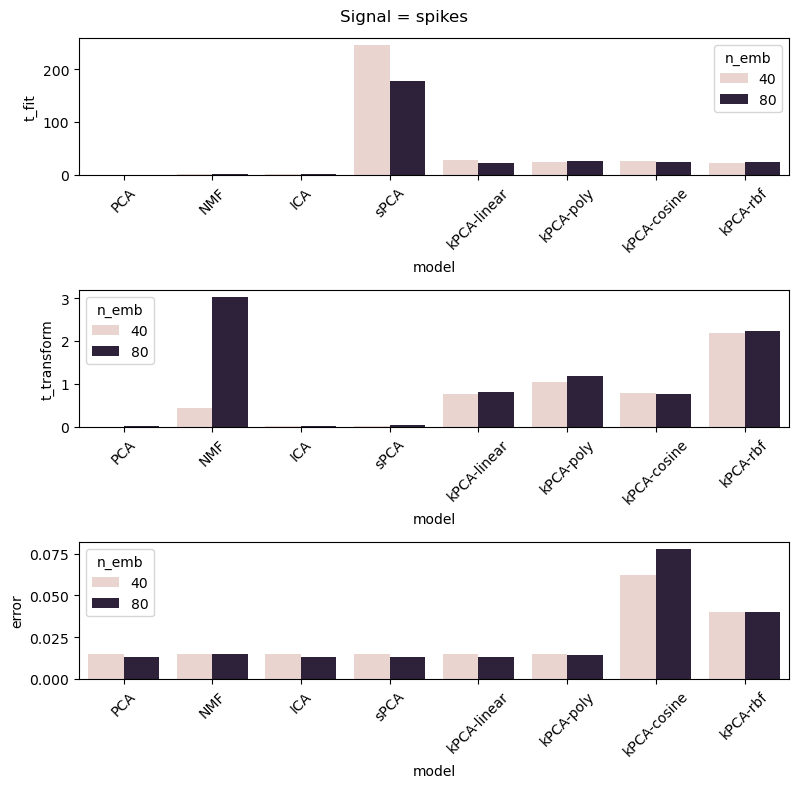

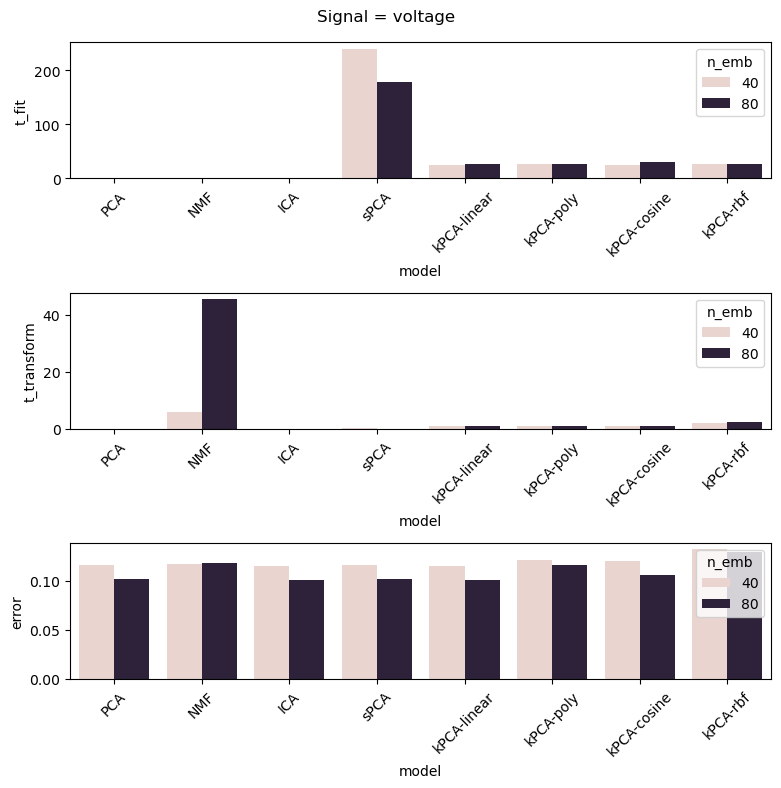

In [87]:
df = df.loc[df.model != "Isomap", :]

for signal in ["spikes", "voltage"]:
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    plt.suptitle(f"Signal = {signal}")
    for i, y in enumerate(["t_fit", "t_transform", "error"]):
        ax = axes[i]
        subdf = df.loc[df.signal == signal, :]
        seaborn.barplot(subdf, x="model", y=y, hue="n_emb", ax=ax)
        ax.set_xticklabels(model_names, rotation=45)
    plt.tight_layout()

### Process data

In [5]:
%%time
brain_arr_train = prepare_brain_data_for_whisper(data_res_train['brain_list'], pca)
brain_arr_train.shape

CPU times: total: 3.7 s
Wall time: 35.1 s


(8800, 80, 3000)

In [9]:
%%time
brain_arr_test = prepare_brain_data_for_whisper(data_res_test['brain_list'], pca)
brain_arr_test.shape

CPU times: total: 203 ms
Wall time: 2.31 s


(880, 80, 3000)

For me it has more of both elements than the majority of its competitors.


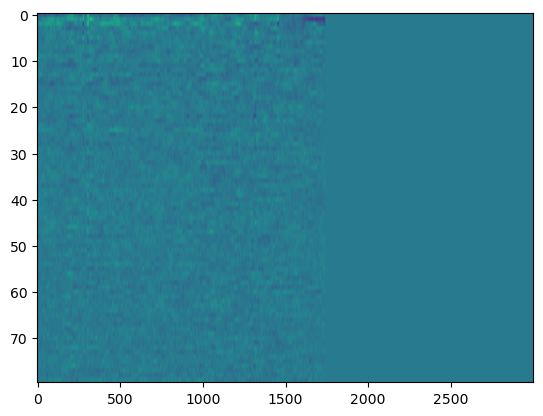

In [36]:
plt.imshow(brain_arr_train[100], aspect='auto')
print(data_res_train['sentence_list'][100])

## Process SENTENCES

In [48]:
from transformers import WhisperTokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", task="transcribe")

In [85]:
sentences_train = data_res_train['sentence_list']
sentences_test  = data_res_test['sentence_list']

### Test how casing affects tokenization

In [44]:
i = 0
s1 = sentences_test[i]
s2 = process_string(sentences_test[i])

d1 = tokenizer(s1).input_ids
d2 = tokenizer(s2).input_ids

s1_pred = tokenizer.decode(d1)
s2_pred = tokenizer.decode(d2)

print(s1)
print(d1)
print(s1_pred)

print(s2)
print(d2)
print(s2_pred)

Theocracy reconsidered.
[50257, 50358, 50362, 464, 17818, 23898, 3089, 13, 50256]
<|startoftranscript|><|transcribe|><|notimestamps|>Theocracy reconsidered.<|endoftext|>
theocracy reconsidered
[50257, 50358, 50362, 1169, 17818, 23898, 3089, 50256]
<|startoftranscript|><|transcribe|><|notimestamps|>theocracy reconsidered<|endoftext|>


### Process all strings and save to a text file

In [92]:
import string

# version with lowering the case - AFFECTS tokenization!
def process_string(text):
    text = text.lower()
    punctuation = string.punctuation.replace("'", "")
    text = ''.join(char for char in text if char not in punctuation)
    return text

# also affects tokenization but we don't care about punctuation!
def remove_punctuation(text):
    punctuation = string.punctuation.replace("'", "")
    text = ''.join(char for char in text if char not in punctuation)
    return text


def save_sentences_to_txt(fpath, sentences, string_processing_fn):
    with open(fpath, 'w', encoding="utf-8") as file:
        for sentence in sentences:
            file.write(string_processing_fn(sentence) + "\n")
            
            
def load_sentences_from_txt(fpath):
    with open(fpath, 'r', encoding="utf-8") as f:
        sentences = [line.strip() for line in f.readlines()]
    return sentences

In [98]:
string_processing_fn = process_string

fname_train = "whisper_sentences_train.txt"
save_sentences_to_txt(data_path / fname_train, data_res_train['sentence_list'], string_processing_fn)

fname_test = "whisper_sentences_test.txt"
save_sentences_to_txt(data_path / fname_test, data_res_test['sentence_list'], string_processing_fn)

In [100]:
sentences_test = load_sentences_from_txt(data_path / "whisper_sentences_test.txt")
sentences_train = load_sentences_from_txt(data_path / "whisper_sentences_train.txt")

sentences_train[0]

'nuclear rockets can destroy airfields with ease'

## Prepare Whisper dataset

### Sentence tokenizer

In [28]:
from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizer
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny.en")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", task="transcribe")

### Prepare dataset

In [81]:
class BrainDataset(Dataset):
    def __init__(self, brain_features, sentences, tokenizer):
        self.brain_features = brain_features
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.brain_features)

    def __getitem__(self, idx):
        input_features = self.brain_features[idx]
        sentence = self.sentences[idx]

        # Tokenize the sentence
        labels = self.tokenizer(sentence, return_tensors="pt").input_ids.squeeze()

        return {
            "input_features": torch.tensor(input_features),
            "labels": labels,
        }

# Create training and evaluation datasets
train_dataset = BrainDataset(brain_arr_train, sentences_train, tokenizer)
eval_dataset = BrainDataset(brain_arr_test, sentences_test, tokenizer)

In [82]:
train_dataset[0]

{'input_features': tensor([[ 5.3771,  6.0706,  5.4985,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4956,  0.0681, -0.3296,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2867, -1.2222, -1.1686,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.4317,  0.4389,  0.6194,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1586,  0.0664, -0.1886,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4949,  0.3686,  0.1017,  ...,  0.0000,  0.0000,  0.0000]],
        dtype=torch.float64),
 'labels': tensor([50257, 50358, 50362,    45,  4016, 20293,   460,  4117,  1633, 25747,
           351, 10152,    13, 50256])}

In [86]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    
    feature_extractor: Any
    tokenizer: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # first treat the BRAIN INPUTS (already preprocessed)
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [89]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

NameError: name 'model' is not defined

In [2]:
""" LOAD PRETRAINED MODEL COMPONENTS """

import torch
from torch import nn
from torch import functional as F

WHISPER_MODEL_NAME = "openai/whisper-tiny.en"

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# load feature/label processing engines
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe")
# load model
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)
#model.generation_config.language = "english"
#model.generation_config.task = "transcribe"
#model.generation_config.forced_decoder_ids = None

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from torchsummary import summary
summary(model);

Layer (type:depth-idx)                             Param #
├─WhisperModel: 1-1                                --
|    └─WhisperEncoder: 2-1                         --
|    |    └─Conv1d: 3-1                            92,544
|    |    └─Conv1d: 3-2                            442,752
|    |    └─Embedding: 3-3                         (576,000)
|    |    └─ModuleList: 3-4                        7,096,320
|    |    └─LayerNorm: 3-5                         768
|    └─WhisperDecoder: 2-2                         --
|    |    └─Embedding: 3-6                         19,915,776
|    |    └─WhisperPositionalEmbedding: 3-7        172,032
|    |    └─ModuleList: 3-8                        9,463,296
|    |    └─LayerNorm: 3-9                         768
├─Linear: 1-2                                      19,915,776
Total params: 57,676,032
Trainable params: 57,100,032
Non-trainable params: 576,000


In [3]:
model.get_decoder()

WhisperDecoder(
  (embed_tokens): Embedding(51864, 384, padding_idx=50256)
  (embed_positions): WhisperPositionalEmbedding(448, 384)
  (layers): ModuleList(
    (0-3): 4 x WhisperDecoderLayer(
      (self_attn): WhisperSdpaAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (activation_fn): GELUActivation()
      (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (encoder_attn): WhisperSdpaAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (e

In [7]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          

In [14]:
for param in model.get_decoder().parameters():
    param.requires_grad = True
    
summary(model);

Layer (type:depth-idx)                             Param #
├─WhisperModel: 1-1                                --
|    └─WhisperEncoder: 2-1                         --
|    |    └─Conv1d: 3-1                            92,544
|    |    └─Conv1d: 3-2                            442,752
|    |    └─Embedding: 3-3                         (576,000)
|    |    └─ModuleList: 3-4                        7,096,320
|    |    └─LayerNorm: 3-5                         768
|    └─WhisperDecoder: 2-2                         --
|    |    └─Embedding: 3-6                         19,915,776
|    |    └─WhisperPositionalEmbedding: 3-7        172,032
|    |    └─ModuleList: 3-8                        9,463,296
|    |    └─LayerNorm: 3-9                         768
├─Linear: 1-2                                      19,915,776
Total params: 57,676,032
Trainable params: 57,100,032
Non-trainable params: 576,000
